In [21]:
# cell used to import important library of the notebook
import numpy as np
import sys
from scipy import sparse
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import networkx as nx
from sklearn.preprocessing import StandardScaler
from utils import * # contains all helper functions used in the project

# I. Load, clean, study and prepare the data for graph creation
## I.1 Data cleaning & preperation
**Preparing IRS data**

In [22]:
#load the data
df_migrations = pd.read_csv("./NTDS_Data/countyinflow1516.csv" )
# create the combined fips county number of destination
df_migrations['statefips_str'] = df_migrations['y2_statefips'].apply(lambda x : str(x).zfill(2))
df_migrations['countyfips_str'] = df_migrations['y2_countyfips'].apply(lambda x : str(x).zfill(3))
df_migrations['combined_fips-destination'] = df_migrations['statefips_str'].apply(lambda x: x.lstrip('0')) + df_migrations['countyfips_str']

# create the combined fips county number of source
df_migrations['statefips_str1'] = df_migrations['y1_statefips'].apply(lambda x : str(x).zfill(2))
df_migrations['countyfips_str1'] = df_migrations['y1_countyfips'].apply(lambda x : str(x).zfill(3))
df_migrations['combined_fips-source'] = df_migrations['statefips_str1'].apply(lambda x: x.lstrip('0')) + df_migrations['countyfips_str1']


# Cleaning the data to have only source and origin counties and unemployment rate as a new column
df_migrations = df_migrations[df_migrations['y1_statefips']<=56]
df_migrations["Unemployment rate"] = df_migrations["n1"]/(df_migrations["n2"] +df_migrations["n1"] )

# drop useless information 
df_migrations = df_migrations.drop(columns=["y1_countyname","y2_statefips", "y2_countyfips", "y1_statefips", "y1_countyfips", "y1_state", "statefips_str", "countyfips_str","statefips_str1", "countyfips_str1"])

# remove nodes where data is undefined undefined data by zero
df_migrations = df_migrations[df_migrations['n1'] != -1]

# convert combined fips to int64
df_migrations['combined_fips-destination'] = df_migrations['combined_fips-destination'].astype('int64')
df_migrations['combined_fips-source'] = df_migrations['combined_fips-source'].astype('int64')

#extracting the combined fips destination and combined fips source for graph in form of numpy arrays
df_graph= df_migrations.drop(columns=["n1","n2","agi","Unemployment rate"])

# extracting all the combinations that have happened in the US between county
dest_source = df_graph.to_numpy()

# reset index starting from 0 (because rows were dropped)
df_migrations = df_migrations.reset_index()
df_migrations = df_migrations.drop(columns=['index'])

**From the IRS dataset create adjency matrix**  
In this adjency matrix, the nodes are the counties and the edges are :
- `A_total[i, j]` := total number of people who migrated from county i to county j
- `A_returns[i, j]` := number of people who migrated from i to j and payed taxes 
- `A_exempt[i, j]` := number of people who migrated from county i to county j and did not payed taxes


In [23]:
nodes_index = np.unique(dest_source)
num_nodes = nodes_index.shape[0]
A_total = np.zeros((num_nodes, num_nodes))
A_returns = np.zeros((num_nodes, num_nodes))
A_exemptions = np.zeros((num_nodes, num_nodes))
count = 0
for dest, source in dest_source : 
    i = np.where(nodes_index == dest)
    j = np.where(nodes_index == source)
    total = df_migrations["n1"][count] + df_migrations["n2"][count]
    
    A_total[j[0], i[0]] = df_migrations["n1"][count] + df_migrations["n2"][count]
    A_returns[j[0], i[0]] = df_migrations["n1"][count]/total
    A_exemptions[j[0], i[0]] = df_migrations["n2"][count]/total
    count += 1

**Preparing the presidential result by county dataset**   
The main idea in this cell is to prepare the presidential result by county dataset. To each county a label is given : $+1$ if the county has a majority of Republican and $-1$ if the county has a majority of Democrat

In [24]:
df_presidential_result = pd.read_csv("./NTDS_Data/2016_US_County_Level_Presidential_Results.csv" )
df_presidential_result = df_presidential_result.drop(columns=["Unnamed: 0","votes_dem", "votes_gop", "total_votes", "diff", "per_point_diff", "state_abbr", "county_name"])

#Sorting according to the fips code to be consistent with the migration data by IRS
df_presidential_result = df_presidential_result.sort_values(by=['combined_fips'])

#Adding a new column of the winners with -1 corresponding to democrat and 1 to republican

df_presidential_result["Winner"] =  np.where((df_presidential_result['per_dem'] > df_presidential_result['per_gop']), -1, 1)

df_presidential_result = df_presidential_result.drop(columns=["per_dem","per_gop"])

# Redindex some FIPS due to difference between FIPS
test = nodes_index - df_presidential_result["combined_fips"].values
df_presidential_result["combined_fips"] = df_presidential_result["combined_fips"] + test

## I.2 Study the datasets at hand 
First we study the proportion of people paying taxes and not paying taxes for each migration flow. An histogram of these migration is plotted.  
As one can see, on average, $35$% of the people in a migration flow are paying taxes (and conversly $65$% are exempt from paying taxes).   
At most, $50$% of the people in a migration flow will pay taxes. Hence, it is intersting to note that most people who migrate are not exempt from paying taxes. 
In subsequent part of this notebook, we will try to see if we can use these proportions to predict if a county is either voting Republican or Democrat. 

In [25]:
# <returns, exempt>
node_pct = np.zeros((df_migrations.shape[0], 2))
for i in range (0, df_migrations.shape[0]) : 
    total = df_migrations['n1'][i] + df_migrations['n2'][i]
    node_pct[i, 0] = df_migrations['n1'][i] / total
    node_pct[i, 1] = df_migrations['n2'][i] / total
df_node_pct = pd.DataFrame(node_pct, columns=["pct_return", "pct_exempt"])

/home/xzou/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


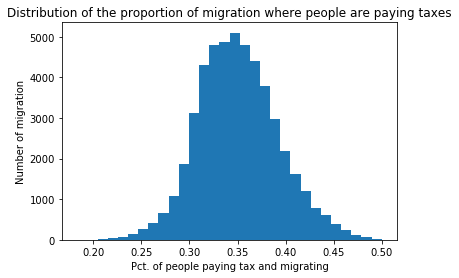

In [26]:
plt.hist(df_node_pct["pct_return"].values, normed=False, bins=30)
plt.title('Distribution of the proportion of migration where people are paying taxes')
plt.ylabel('Number of migration');
plt.xlabel('Pct. of people paying tax and migrating');

/home/xzou/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


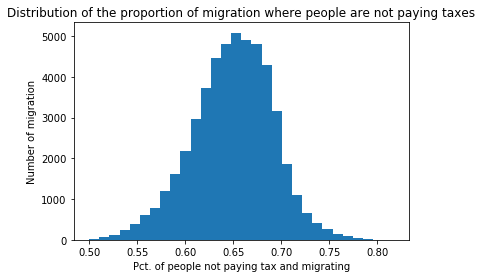

In [27]:
plt.hist(df_node_pct["pct_exempt"].values, normed=False, bins=30)
plt.title('Distribution of the proportion of migration where people are not paying taxes')
plt.ylabel('Number of migration');
plt.xlabel('Pct. of people not paying tax and migrating');

One wants to also consider the proportion of Republican and Democrat counties in the US. Before doing the actual computation, a bit of historic background on the US electoral system is required. 
Historically, most of the states in the US are Republican. Hence, if one draws a simple geographic map of the US, he would color most states in red (the color of the Rebublican). However, if then one scales the size each state with the number of inhabitants in each county, then the proportion of blue and red on the map would be more or less equal, with coastal states (states that are on the Atlantic or Pacific coast) in blue, and the inner states red (Republican). 
Our computations verify this historical proportions : more than $84$% of the counties are Republican. 

In [28]:
pct_republican = df_presidential_result[df_presidential_result['Winner'] == 1].shape[0] / df_presidential_result.shape[0]
pct_democrat = df_presidential_result[df_presidential_result['Winner'] == -1].shape[0] / df_presidential_result.shape[0]
print("Pct. of counties Republican : ", pct_republican, " // Pct. of counties Democrat : ", pct_democrat)

Pct. of counties Republican :  0.8449538363578478  // Pct. of counties Democrat :  0.15504616364215218


# II. Creation of simple graph following structure of migration & first attempt to predict county type
## II.1 Creation of simple graph
The first graphs that will be studied in this notebook are simple to understand as they follow the structure of a migration : if there is a migration between county i and j, then an edge is set between these to counties. 
Before moving on, it is intersting to note that in this section, we are creating graph that are suppose to show a correlation between a type of migration and a voting pattern in a county. 
When we refer to "type of migration", we mean what kind of proportion is there between people paying taxes and not paying taxes in a specific migration flow. For exemple, we say that a migration flow has a high proportion of people paying taxes if more then $40$% of the people in the migration flow are paying taxes. The idea is to correlate this migration to a specific voting pattern in the destination county. 
To achieve this task we will be creating 2 types of graph : 
- `graph_nonRGB_returns` : in these graph there is a migration between two counties if (1) there is an actual migration between county i and j and (2) if the migration flow as a proportion of people paying taxes greater then a **specified threshold**. 
- `graph_nonRGB_exempt`: same type of graph as before, but now we are studying the proportions of exempted people in a migration flow

In subsequent cells, we code mainly two methods : one for creating `graph_nonRGB_return` graphs and one for creating `graph_nonRGB_exempt` 

Note : we refer to graph created in this section as "nonRGB" as in later section we will be using RGB graphs. One can read this notation as being a raw graph built on migration without any kind of similarity extrapolation. 

In [29]:
def create_adjency_nonRGB_returns(threshold_returns, plot_adj_returns=False) : 
    """
    Create the adjency matrix for a graph where there is an edge between two county if migration flow 
    between two county has a proportion of people paying taxes greater than threshold_returns
    """
    adjacency_nonRGB_returns = A_returns.copy()
    adjacency_nonRGB_returns[adjacency_nonRGB_returns >= threshold_returns] = 1
    adjacency_nonRGB_returns[adjacency_nonRGB_returns < threshold_returns] = 0

    if plot_adj_returns : 
        plt.spy(adjacency_nonRGB_returns)
        plt.show()
        
    return adjacency_nonRGB_returns

def create_graph_nonRGB_returns(threshold_returns, plot_adj_returns=False) :
    """
    Create a graph where there is an edge between two county if migration flow 
    between two county has a proportion of people paying taxes greater than threshold_returns
    The attribute plot_adj_returns can is a boolean used if one wants to plot the adjency matrix of the graph
    """
    i = np.where(nodes_index == dest)
    graph_nonRGB_returns = nx.from_numpy_array(create_adjency_nonRGB_returns(threshold_returns, plot_adj_returns))
    nodes = np.zeros((nodes_index.shape[0], 2))
    for fips, result in df_presidential_result.values :
        i = np.where(nodes_index == fips)
        index = i[0][0]
        nodes[index, 0] = index
        nodes[index, 1] = result
   
    node = pd.DataFrame(nodes, columns=["id", "result"])
    node_props = node.to_dict()
    for key in node_props:
        nx.set_node_attributes(graph_nonRGB_returns, node_props[key], key)

    nx.write_gexf(graph_nonRGB_returns, 'graph_nonRGB_returns_35.gexf')
    return graph_nonRGB_returns

def create_graph_nonRGB_returns_features(threshold_returns, plot_adj_returns=False): 
    i = np.where(nodes_index == dest)
    graph_nonRGB_returns = nx.from_numpy_array(create_adjency_nonRGB_returns(threshold_returns, plot_adj_returns))
    nodes = np.zeros((nodes_index.shape[0], 4))
    for fips, result in df_presidential_result.values :
        i = np.where(nodes_index == fips)
        index = i[0][0]
        nodes[index, 0] = index
        nodes[index, 1] = result
   
    for j in range (0, df_migrations.shape[0]): 
        fips = df_migrations['combined_fips-destination'][j]
        i = np.where(nodes_index == fips)
        index = i[0][0]
        nodes[index, 2] = df_migrations['agi'][j]
        nodes[index, 3] = df_migrations['Unemployment rate'][j]
    
    node = pd.DataFrame(nodes, columns=["id", "result", "agi", "unemployment_rate"])
    node_props = node.to_dict()
    for key in node_props:
        nx.set_node_attributes(graph_nonRGB_returns, node_props[key], key)

    nx.write_gexf(graph_nonRGB_returns, 'graph_nonRGB_returns_35.gexf')
    return graph_nonRGB_returns, node

In [40]:
# test if the function create_graph_nonRGB_returns is working
_, features1 = create_graph_nonRGB_returns_features(0.38)

In [34]:
adjacency_nonRGB_returns = create_adjency_nonRGB_returns(0.38, plot_adj_returns=False)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [43]:
# prepare A and x(signal)
A_migration = adjacency_nonRGB_returns.copy()
# define two different targets for migration adjacency matrix
#y_unemployment_rate = df_migrations1["Unemployment rate"].copy()
y_presidential_result = features1["result"].copy()
# compute lamb and U
laplacian_migration = compute_laplacian(A_migration, normalize=True)
lamb_migration, U_migration = spectral_decomposition(laplacian_migration)

3141


In [44]:
# prepare filter
ideal_lp_migration = np.ones((A_migration.shape[0],)) 
ideal_lp_migration[lamb_migration >= 0.1] = 0   # to tune
# apply filter
x_lp_migration = ideal_graph_filter(y_presidential_result.copy(),ideal_lp_migration,U_migration)

3141


In [48]:
iters = 10
n = int(len(y_presidential_result)*0.2)

In [49]:
accuracy_mean_migration, accuracy_var_migration = pred_iteration(A_migration,iters, y_presidential_result, n, x_lp_migration)

The mean is  0.8783787613383739
The variance is  0.012052096120726927


In [52]:
X_migration = features1.drop(columns=['id', 'result']).values

In [54]:
mean_unemployment_rate,var_unemployment_rate = apply_gcn(iters,X_migration,y_presidential_result,A_migration,laplacian_migration,lamb_migration,U_migration)

Computing
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %
The mean of f1 score is  0.9179262282947448
The variance of f1 score is  0.008141397388559221


In [41]:
features1

,id,result,agi,unemployment_rate
0,0.0,1.0,761.0,0.363636
1,1.0,1.0,1848.0,0.307692
2,2.0,1.0,757.0,0.294118
3,3.0,1.0,865.0,0.290323
4,4.0,1.0,1270.0,0.326316
...,...,...,...,...
3136,3136.0,1.0,883.0,0.289855
3137,3137.0,-1.0,1561.0,0.425532
3138,3138.0,1.0,968.0,0.304348
3139,3139.0,1.0,220127.0,0.309895


In [31]:
# construct graph for flows with more then 45% returns 
# create adjacency matrix for flows with more then 45% returns 
def create_adjency_nonRGB_exempt(thershold_exempt, plot_adj_exempt = False ) : 
    """
    Create the adjency matrix for a graph where there is an edge between two county if migration flow 
    between two county has a proportion of people not paying taxes greater than thershold_exempt
    """
    adjacency_nonRGB_exempt = A_exemptions.copy()
    adjacency_nonRGB_exempt[adjacency_nonRGB_exempt >= thershold_exempt] = 1
    adjacency_nonRGB_exempt[adjacency_nonRGB_exempt < thershold_exempt] = 0
    
    if plot_adj_exempt : 
        plt.spy(adjacency_nonRGB_exempt)
        plt.show()
        
    return adjacency_nonRGB_exempt

def create_graph_nonRGB_exempt(threshold_exempt, plot_adj_exempt = False) : 
    """
    Create a graph where there is an edge between two county if migration flow 
    between two county has a proportion of people not paying taxes greater than threshold_exempt
    The attribute plot_adj_exempt can is a boolean used if one wants to plot the adjency matrix of the graph
    """
    i = np.where(nodes_index == dest)
    graph_nonRGB_exempt = nx.from_numpy_array(create_adjency_nonRGB_exempt(threshold_exempt, plot_adj_exempt))
    nodes = np.zeros((nodes_index.shape[0], 2))
    for fips, result in df_presidential_result.values :
        i = np.where(nodes_index == fips)
        index = i[0][0]
        nodes[index, 0] = index
        nodes[index, 1] = result
        
    node = pd.DataFrame(nodes, columns=["id", "result"])
    node_props = node.to_dict()
    for key in node_props:
        nx.set_node_attributes(graph_nonRGB_exempt, node_props[key], key)

    nx.write_gexf(graph_nonRGB_exempt, 'graph_nonRGB_exempt.gexf')
    return graph_nonRGB_exempt

def create_graph_nonRGB_exempt_features(threshold_exempt, plot_adj_exempt = False) :  
    i = np.where(nodes_index == dest)
    graph_nonRGB_exempt = nx.from_numpy_array(create_adjency_nonRGB_exempt(threshold_exempt, plot_adj_exempt))
    nodes = np.zeros((nodes_index.shape[0], 4))
    for fips, result in df_presidential_result.values :
        i = np.where(nodes_index == fips)
        index = i[0][0]
        nodes[index, 0] = index
        nodes[index, 1] = result
    
    for j in range (0, df_migrations.shape[0]): 
        fips = df_migrations['combined_fips-destination'][j]
        i = np.where(nodes_index == fips)
        index = i[0][0]
        nodes[index, 2] = df_migrations['agi'][j]
        nodes[index, 3] = df_migrations['Unemployment rate'][j]
        
    node = pd.DataFrame(nodes, columns=["id", "result", "agi", "unemployment_rate"])
    node_props = node.to_dict()
    for key in node_props:
        nx.set_node_attributes(graph_nonRGB_exempt, node_props[key], key)

    nx.write_gexf(graph_nonRGB_exempt, 'graph_nonRGB_exempt.gexf')
    return graph_nonRGB_exempt, node


In [32]:
# test if the function create_adjency_nonRGB_exempt is working 
_, xiaoyan2 = create_graph_nonRGB_exempt_features(0.56)

## II.2 First attempt at predicting election results
With the graph built in the previous section, we want to see if there is some sort of pattern between a particular structure of the graph and the voting pattern in the county. 
### III.2.1 First observations using Gephi
The first hypothesis that could be stated are the following : 
1. **Hypothesis 1** : a migration flow with a more than 35% people paying taxes will have as destination a republican county. One could think that people paying taxes would like to move to Republican county were taxes such as the proprety tax are lower. 
2. **Hypothesis 2** : a migration flow with a more than 70% people not paying taxes will have as destination a democrat county. One could think that people with the lowest income would move to county were charity is more developed (we are not considering helps from the state, which is the same whatever the state).

To validate or reject these two hypotethis, we are building two graph. The first one considers only the migration flow between counties were more then $38$% of the migrants are paying taxes. The second graph considers only the migration flow between counties were more then $70$% of the migrants are paying taxes. 
If hypothesis 1 is correct, then one can consider then there is 
The adjacency matrix is then build by thresholding each weights. More precisely, we keep only migration that have more than 70% of people not paying taxes, or we keep flows where more than 35% of people are paying taxes. These values were chosen to represent the last quartile of each proportion distribution discussed earlier. 
The graph is then saved into a $gexf$ file and studied with the application $Gephi$. 

In [13]:
def get_degree_attribute (G) :
    degree_attr = [(G.degree(n), G.nodes[n]['result']) for n in G.nodes()]
    return np.array(degree_attr)

def get_degree_party (degree_attr) : 
    democrats = []
    republicans = []
    for tuple_ in degree_attr : 
        if tuple_[1] == -1 : 
            democrats.append(tuple_[0])
        else : 
            republicans.append(tuple_[0])
    return democrats, republicans 

def cross_validation_returns (threshold_range_min, threshold_range_max, step=0.01, print_best=False) : 
    thresholds = np.arange(start=threshold_range_min, stop=threshold_range_max, step=step)
    max_global = 0
    best_cut = 0
    best_threshold = 0
    for threshold in thresholds : 
        graph_nonRGB_returns = create_graph_nonRGB_returns(threshold)
        degree_attr = get_degree_attribute(graph_nonRGB_returns)
        d, r = get_degree_party(degree_attr)
        d = np.array(d)
        r = np.array(r)
        
        d_qt025 = np.quantile(d, 0.25)
        d_qt075 = np.quantile(d, 0.75)
        cuts = np.arange(d_qt025, d_qt075, 1)
        max_local = 0
        cut_local = 0
        for cut in cuts : 
            temp = np.abs(d[d > cut].shape[0]/d.shape[0] - r[r > cut].shape[0]/r.shape[0])
            if temp > max_local : 
                max_local = temp
                cut_local = cut
        
        if max_local > max_global : 
            max_global = max_local
            best_threshold = threshold
            best_cut = cut_local
        
    if print_best : 
        graph_nonRGB_returns = create_graph_nonRGB_returns(best_threshold)
        degree_attr = get_degree_attribute(graph_nonRGB_returns)
        d, r = get_degree_party(degree_attr)
        d = np.array(d)
        r = np.array(r)
        print(d[d > best_cut].shape[0]/d.shape[0])
        print(r[r > best_cut].shape[0]/r.shape[0])   
        plt.hist(d, normed=True, bins= 100)
        plt.show()
        plt.hist(r, normed=True, bins= 100)
        plt.show()
    return best_cut, best_threshold

0.5174537987679672
0.08251695553880935


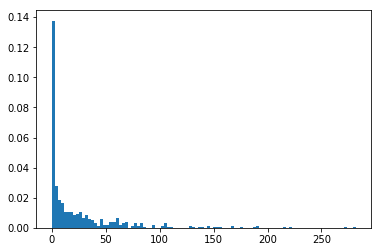

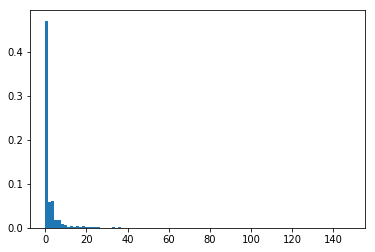

(6.0, 0.38000000000000006)

In [14]:
cross_validation_returns(0.3, 0.6, print_best=True)

In [15]:
#a_dict = graph_nonRGB_returns.neighbors
def compute_mean (neigh_degree) : 
    if neigh_degree.shape[0] == 0 : 
        return 0
    else :
        return neigh_degree.mean()

def mean_degree_neighbors (G) :
    degree_attr = get_degree_attribute(G)
    mean_degree_neigh = []
    dicts = [G.neighbors(n) for n in G.nodes]
    for a_dict in dicts : 
        neigh_degree = []
        for key in a_dict:
            neigh_degree.append(degree_attr[key][0])        
        mean_degree_neigh.append(compute_mean(np.array(neigh_degree)))
    return np.concatenate((np.array(mean_degree_neigh).reshape(degree_attr.shape[0], 1), degree_attr[:, 1].reshape(degree_attr.shape[0], 1)), axis=1)

def cross_validation_neigh_returns (threshold_range_min, threshold_range_max, step=0.01, print_best=False) : 
    thresholds = np.arange(start=threshold_range_min, stop=threshold_range_max, step=step)
    max_global = 0
    best_cut = 0
    best_threshold = 0
    for threshold in thresholds : 
        graph_nonRGB_returns = create_graph_nonRGB_returns(threshold)
        degree_attr = mean_degree_neighbors(graph_nonRGB_returns)
        d, r = get_degree_party(degree_attr)
        d = np.array(d)
        r = np.array(r)
        d_qt025 = np.quantile(d, 0.25)
        d_qt075 = np.quantile(d, 0.75)

        cuts = np.arange(d_qt025, d_qt075, 1)
        max_local = 0
        cut_local = 0
        for cut in cuts : 
            temp = np.abs(d[d > cut].shape[0]/d.shape[0] - r[r > cut].shape[0]/r.shape[0])
            if temp > max_local : 
                max_local = temp
                cut_local = cut
        
        if max_local > max_global : 
            max_global = max_local
            best_threshold = threshold
            best_cut = cut_local
        
    if print_best : 
        graph_nonRGB_returns = create_graph_nonRGB_returns(best_threshold)
        degree_attr = mean_degree_neighbors(graph_nonRGB_returns)
        d, r = get_degree_party(degree_attr)
        d = np.array(d)
        r = np.array(r)
        print(d[d > best_cut].shape[0]/d.shape[0])
        print(r[r > best_cut].shape[0]/r.shape[0])   
        plt.hist(d, normed=True, bins= 100)
        plt.show()
        plt.hist(r, normed=True, bins= 100)
        plt.show()
    return best_cut, best_threshold

0.7002053388090349
0.2629992464204974


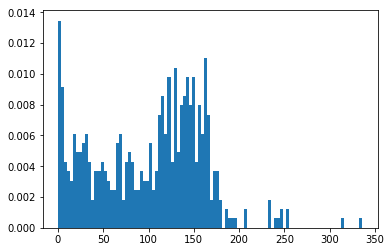

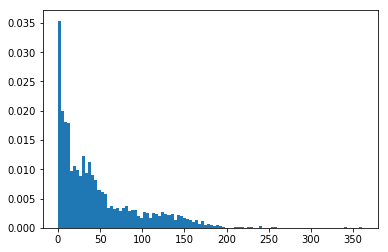

best cut is :  62.86904761904762  // best thershold us :  0.31


In [16]:
best_cut, best_thershold = cross_validation_neigh_returns(0.3, 0.6, print_best=True)
print("best cut is : ", best_cut, " // best thershold us : ", best_thershold)

In [17]:
def cross_validation_neigh_exempt (threshold_range_min, threshold_range_max, step=0.01, print_best=False) : 
    thresholds = np.arange(start=threshold_range_min, stop=threshold_range_max, step=step)
    max_global = 0
    best_cut = 0
    best_threshold = 0
    for threshold in thresholds : 
        graph_nonRGB_exempt = create_graph_nonRGB_exempt(threshold)
        degree_attr = mean_degree_neighbors(graph_nonRGB_exempt)
        d, r = get_degree_party(degree_attr)
        d = np.array(d)
        r = np.array(r)
        d_qt025 = np.quantile(d, 0.25)
        d_qt075 = np.quantile(d, 0.75)

        cuts = np.arange(d_qt025, d_qt075, 1)
        max_local = 0
        cut_local = 0
        for cut in cuts : 
            temp = np.abs(d[d > cut].shape[0]/d.shape[0] - r[r > cut].shape[0]/r.shape[0])
            if temp > max_local : 
                max_local = temp
                cut_local = cut
        
        if max_local > max_global : 
            max_global = max_local
            best_threshold = threshold
            best_cut = cut_local
        
    if print_best : 
        graph_nonRGB_exempt = create_graph_nonRGB_exempt(best_threshold)
        degree_attr = mean_degree_neighbors(graph_nonRGB_exempt)
        d, r = get_degree_party(degree_attr)
        d = np.array(d)
        r = np.array(r)
        print(d[d > best_cut].shape[0]/d.shape[0])
        print(r[r > best_cut].shape[0]/r.shape[0])   
        plt.hist(d, normed=True, bins= 100)
        plt.show()
        plt.hist(r, normed=True, bins= 100)
        plt.show()
    return best_cut, best_threshold

0.6468172484599589
0.2162773172569706


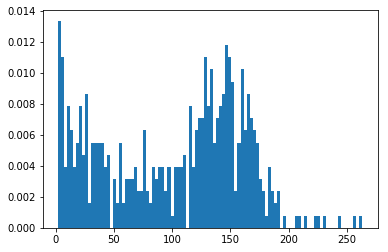

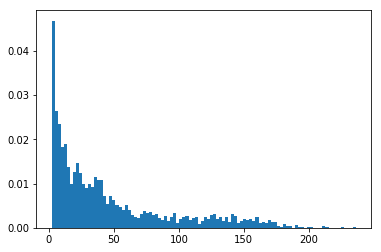

best cut is :  75.69047619047619  // best thershold us :  0.56


In [18]:
best_cut, best_thershold = cross_validation_neigh_exempt(0.55, 0.8, print_best=True)
print("best cut is : ", best_cut, " // best thershold us : ", best_thershold)